In [1]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles, count_boundary_atoms_products_and_calculate_changes, calculate_chemical_properties


/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['fragment_count']>8, 'fragment_count'] = '> 8'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. V

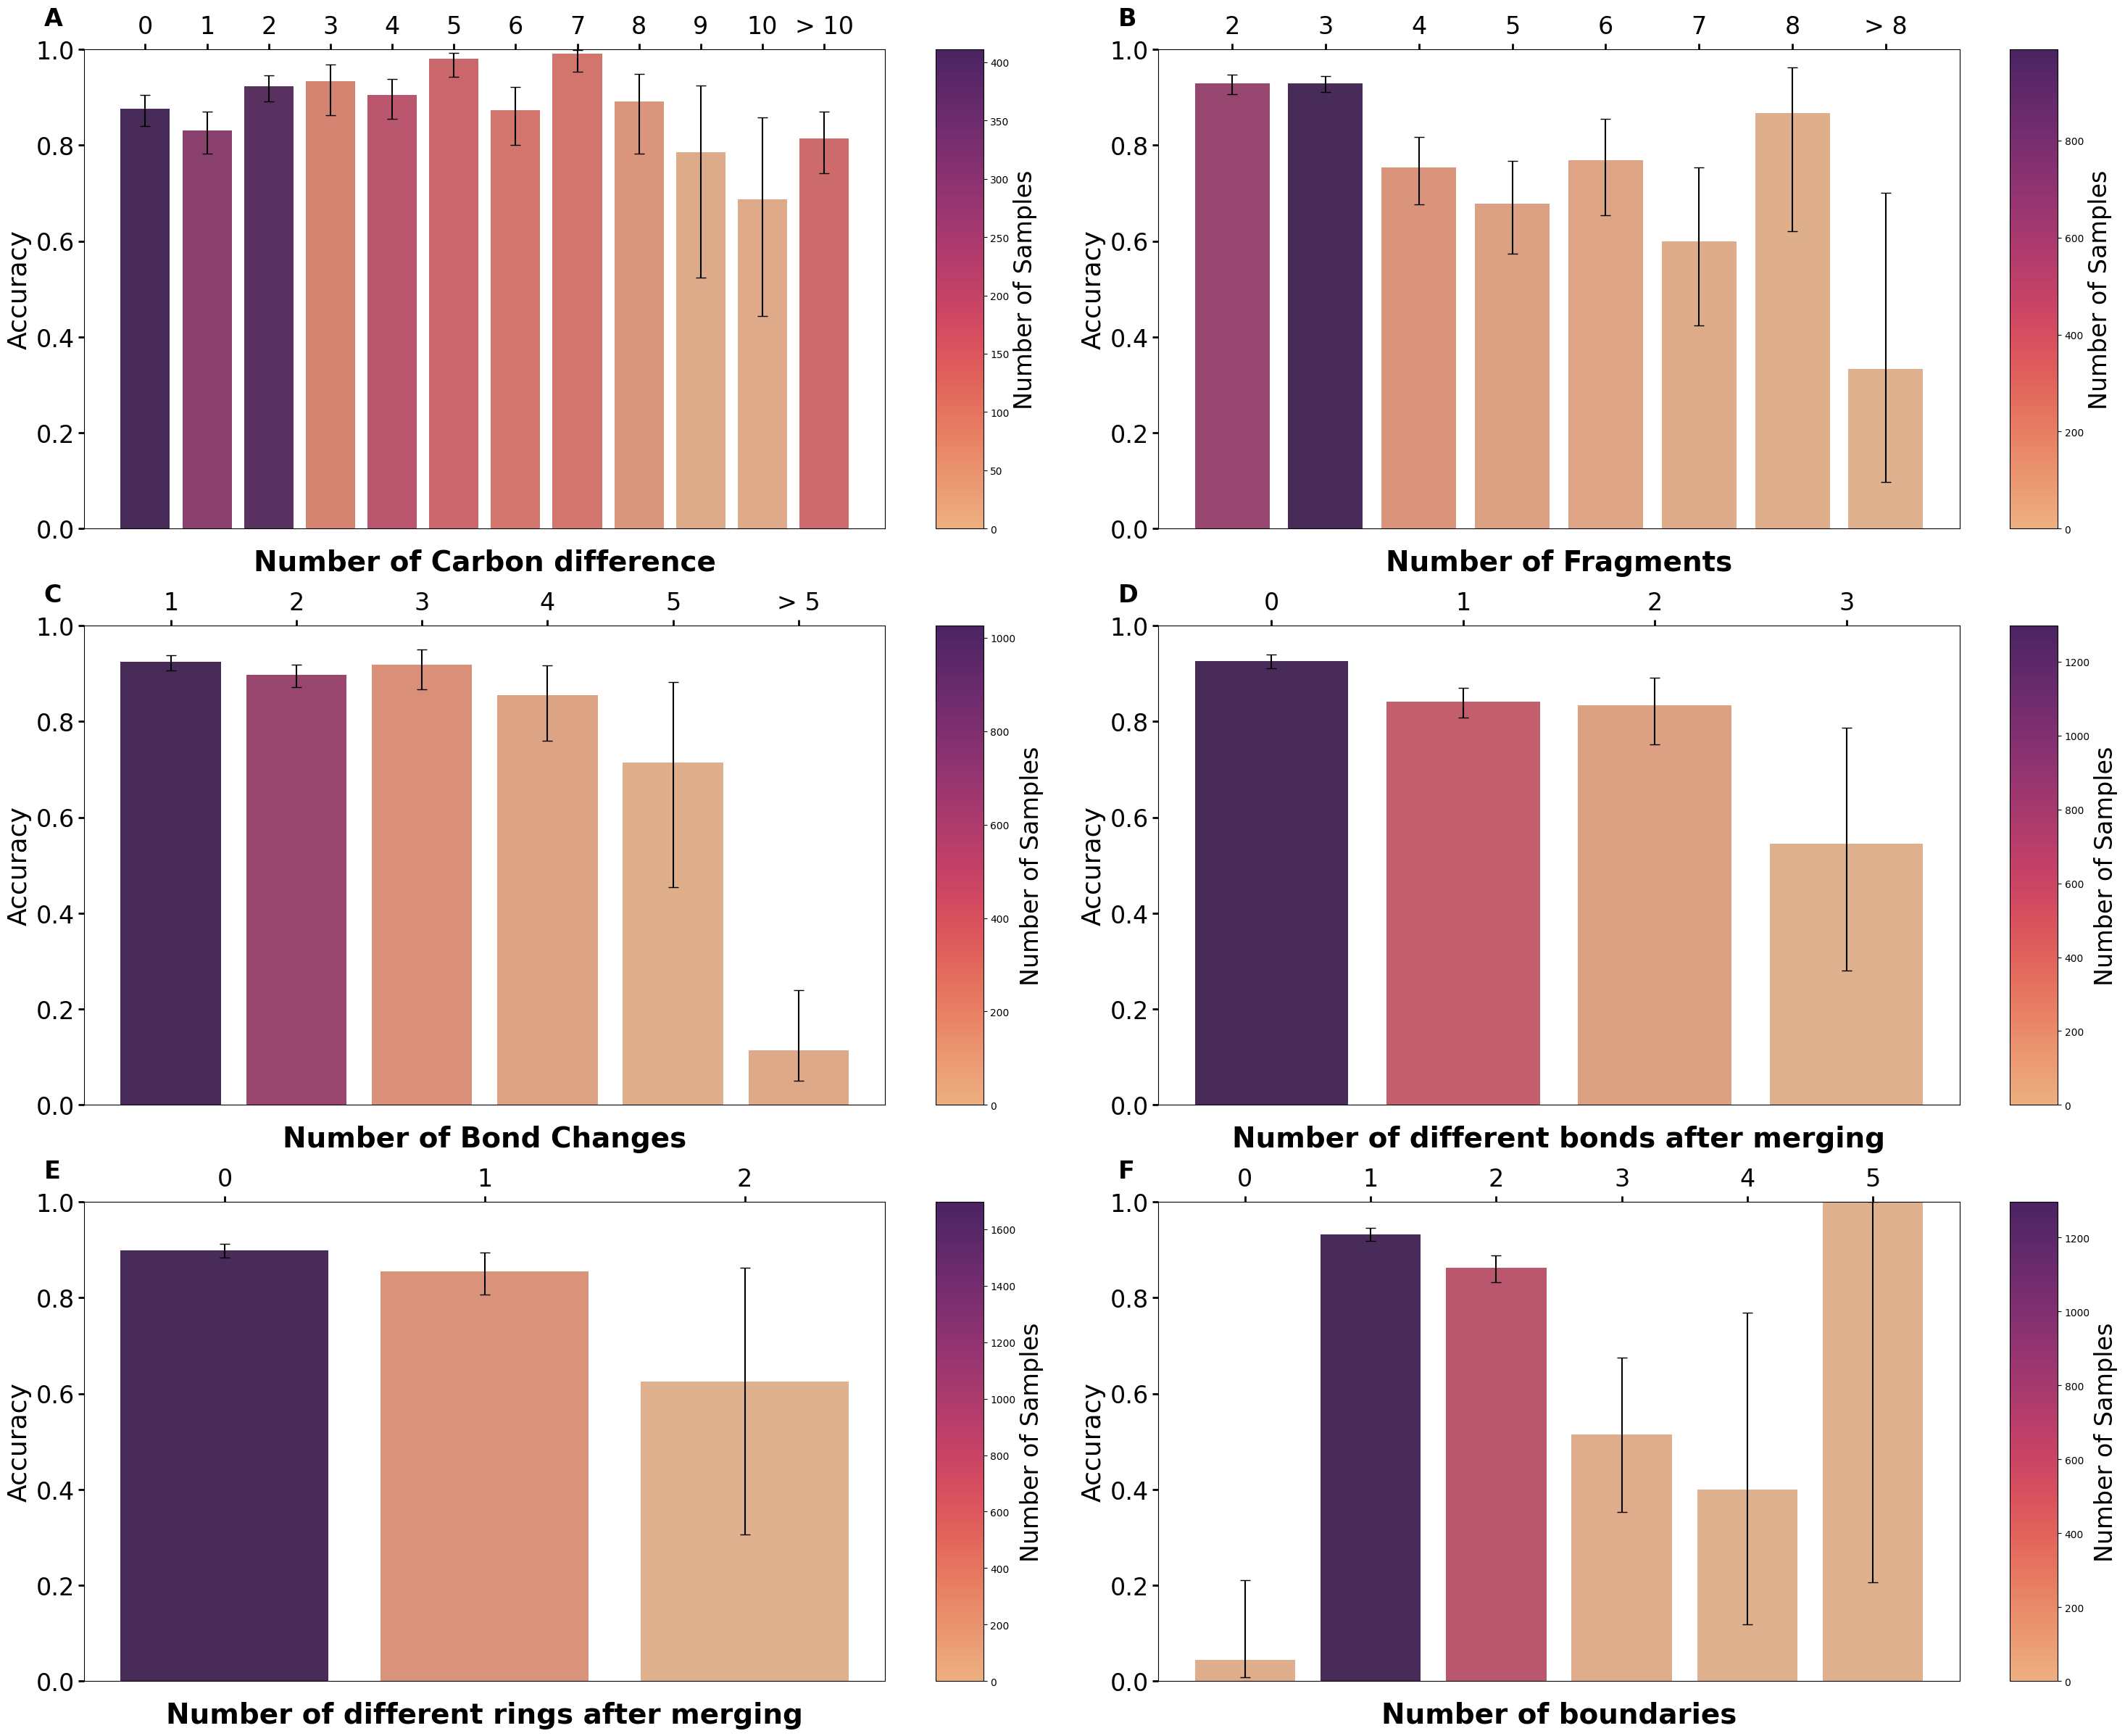

In [4]:
from SynAnalysis.analysis_process import AnalysisProcess
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)

data = process.process_and_combine_datasets(remove_undetected=True)
data_all = process.standardize_columns(data)
from SynAnalysis.eda_analysis import EDAVisualizer

columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
titles = ['Number of Carbon difference', 'Number of Fragments', 'Number of Bond Changes', 'Number of different bonds after merging', 
          'Number of different rings after merging', 'Number of boundaries']
visualizer = EDAVisualizer(data_all, columns, titles)
visualizer.visualize_accuracy(chart_type='bar', show_values=False, error_bar=True, save_path='./EDA.pdf')

/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['carbon_difference']>10, 'carbon_difference'] = '> 10'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '> 8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['fragment_count']>8, 'fragment_count'] = '> 8'
/homes/biertank/tieu/Documents/Project/SynRBL/Pipeline/Validation/Analysis/SynAnalysis/analysis_process.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. V

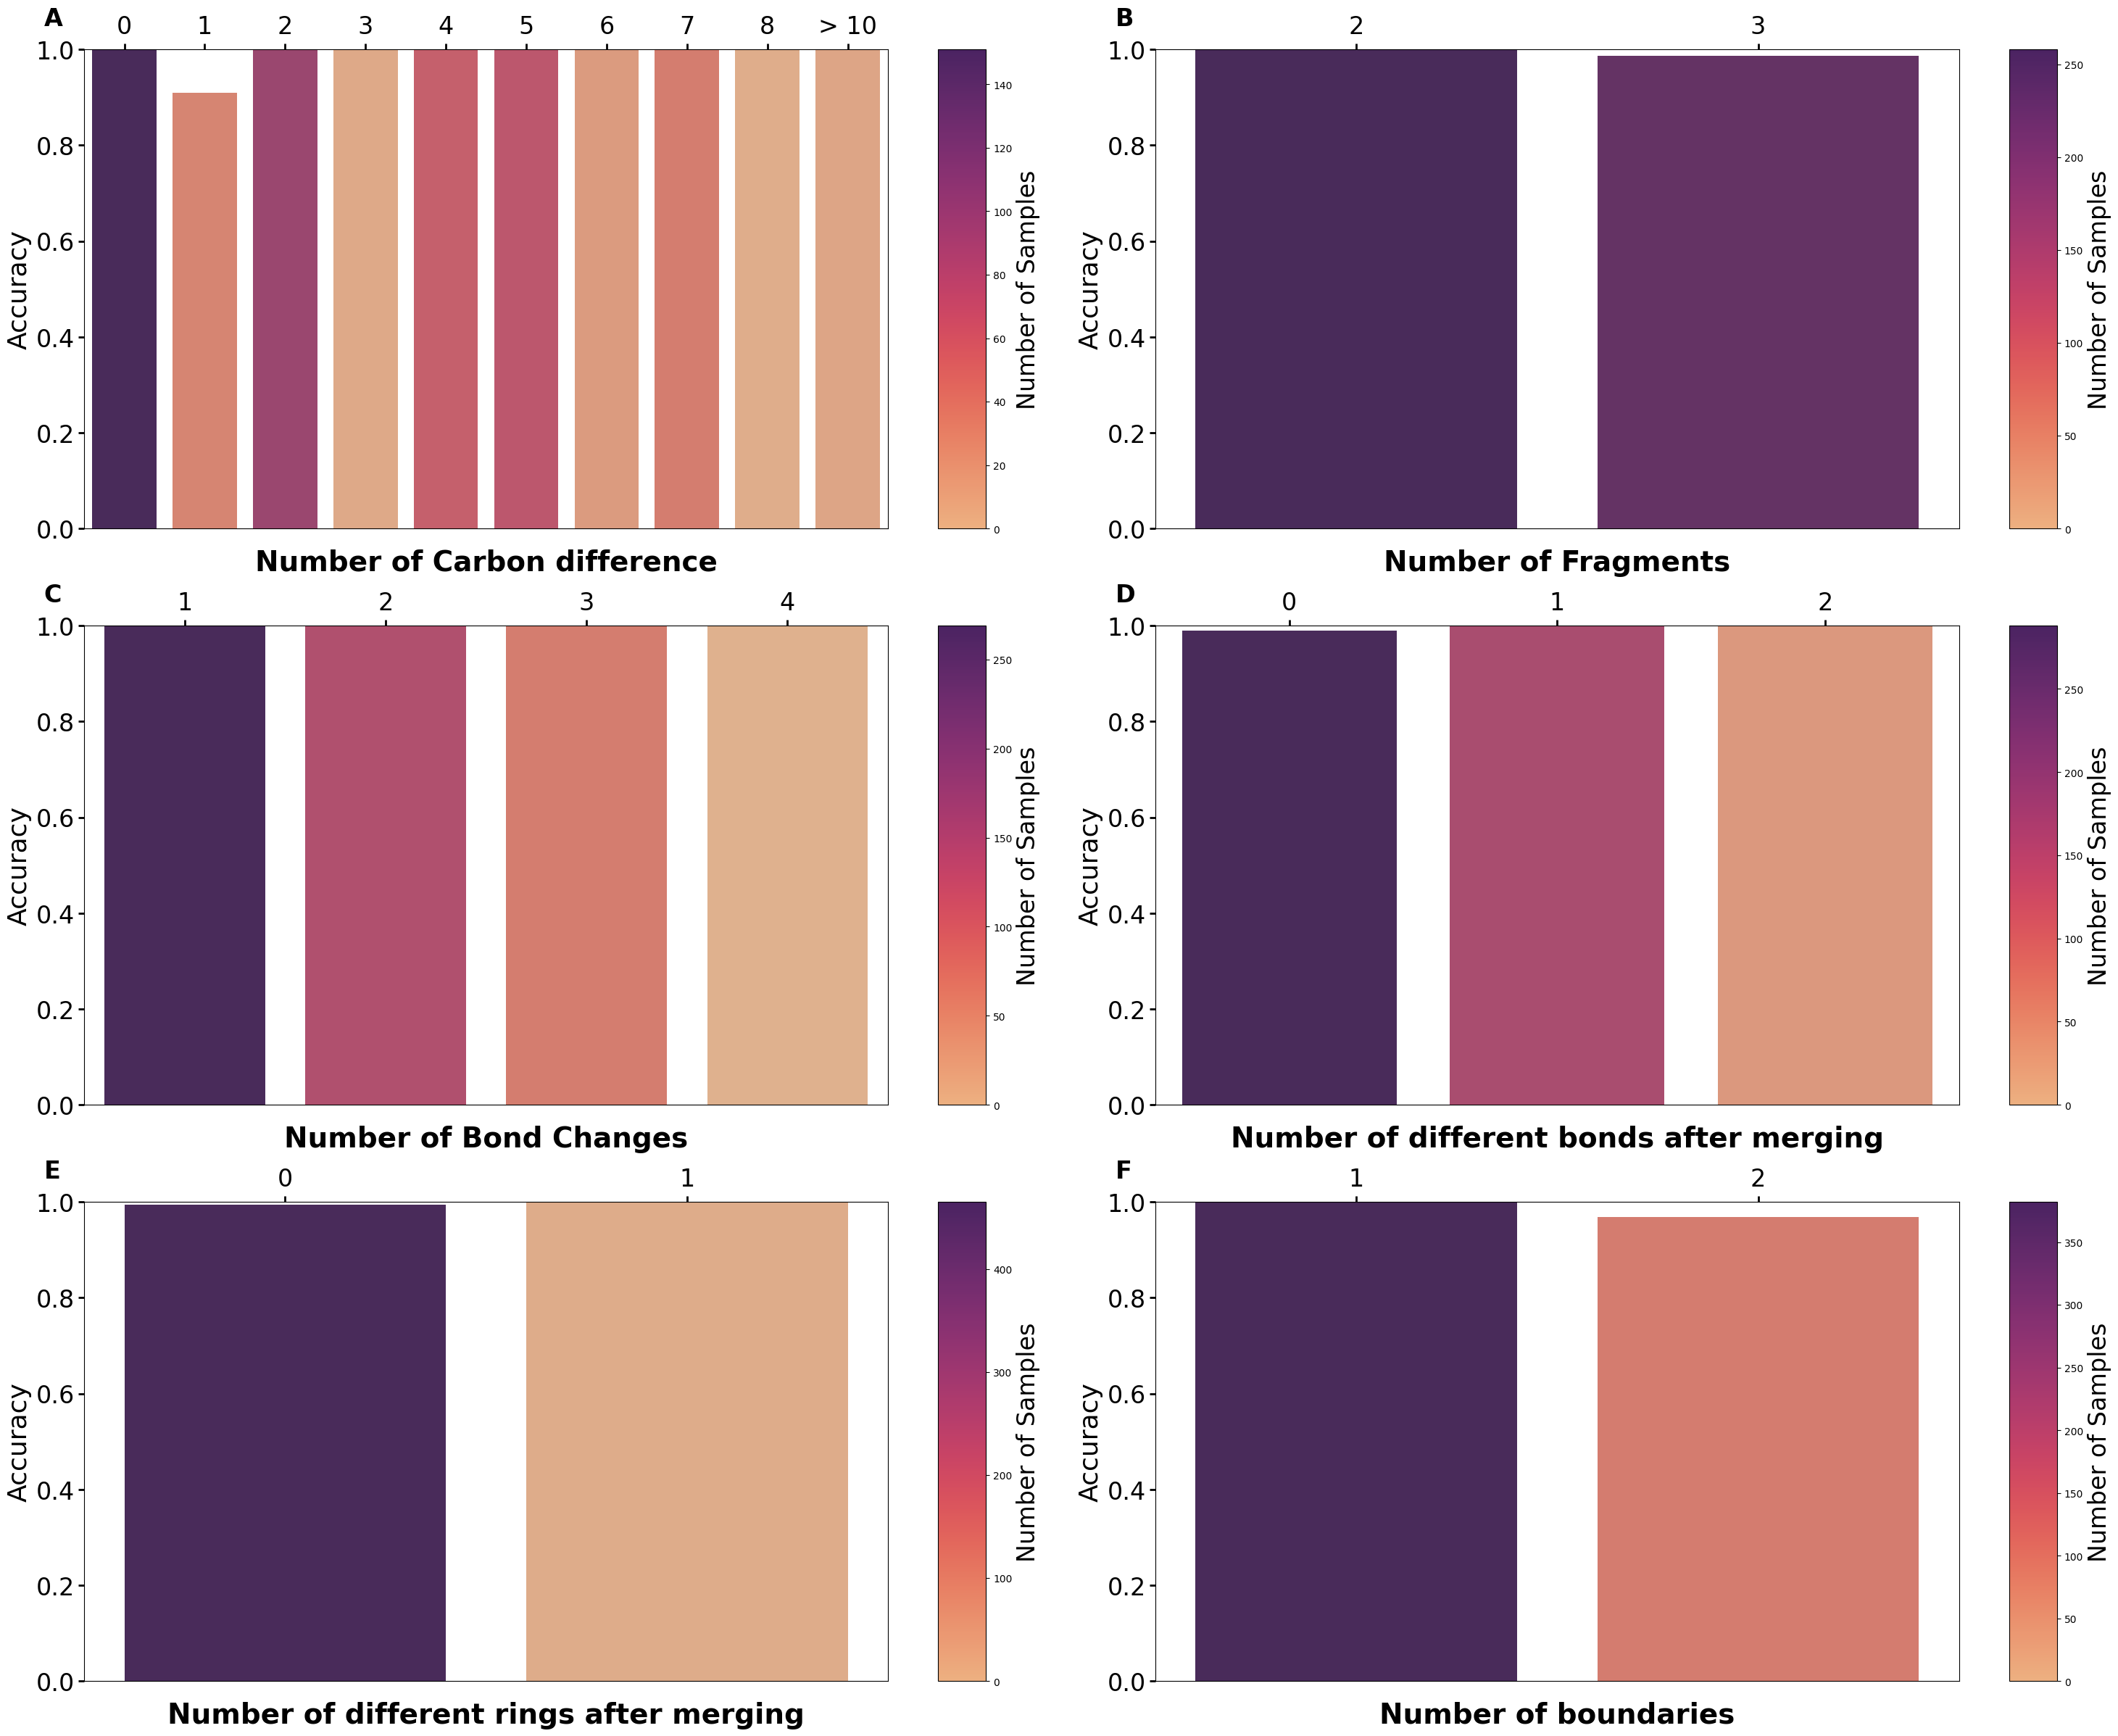

In [31]:
#from SynAnalysis.analysis_process import AnalysisProcess
#list_data_all = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
list_data_all = ['USPTO_random_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
for list_data in list_data_all:
    process = AnalysisProcess([list_data], pipeline_path, data_path)
    data = process.process_and_combine_datasets(remove_undetected=True)
    data_all = process.standardize_columns(data)
    from SynAnalysis.eda_analysis import EDAVisualizer

    columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
    titles = ['Number of Carbon difference', 'Number of Fragments', 'Number of Bond Changes', 'Number of different bonds after merging', 
            'Number of different rings after merging', 'Number of boundaries']
    visualizer = EDAVisualizer(data_all, columns, titles)
    visualizer.visualize_accuracy(chart_type='bar', show_values=False, error_bar=False, save_path=f'./{list_data}_EDA.pdf')

In [27]:
data_all.describe(include='all')

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
count,255,255,255.0,255.0,255.000000,255.000000,255.000000,255.000000,255,255.0,255,255.000000,255.000000,255.0
unique,255,255,9.0,2.0,NaN,NaN,NaN,NaN,2,5.0,1,NaN,NaN,3.0
top,USPTO_unbalance_class_0,CCOC(=O)c1nc(-c2ccccc2)cs1>>O=C(O)c1nc(-c2cccc...,2.0,3.0,NaN,NaN,NaN,NaN,True,1.0,True,NaN,NaN,0.0
freq,1,1,56.0,210.0,NaN,NaN,NaN,NaN,247,179.0,255,NaN,NaN,222.0
mean,NaN,NaN,NaN,NaN,41.039216,5.921569,0.435294,127.113725,NaN,NaN,NaN,1.184314,0.121569,NaN
std,NaN,NaN,NaN,NaN,15.877683,3.313318,0.496770,73.943682,NaN,NaN,NaN,0.408267,0.327430,NaN
min,NaN,NaN,NaN,NaN,8.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,29.500000,3.000000,0.000000,63.500000,NaN,NaN,NaN,1.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,39.000000,7.000000,0.000000,127.000000,NaN,NaN,NaN,1.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,50.000000,9.000000,1.000000,190.500000,NaN,NaN,NaN,1.000000,0.000000,NaN


In [29]:
data['fragment_count'].value_counts()

fragment_count
3    210
2     45
Name: count, dtype: int64

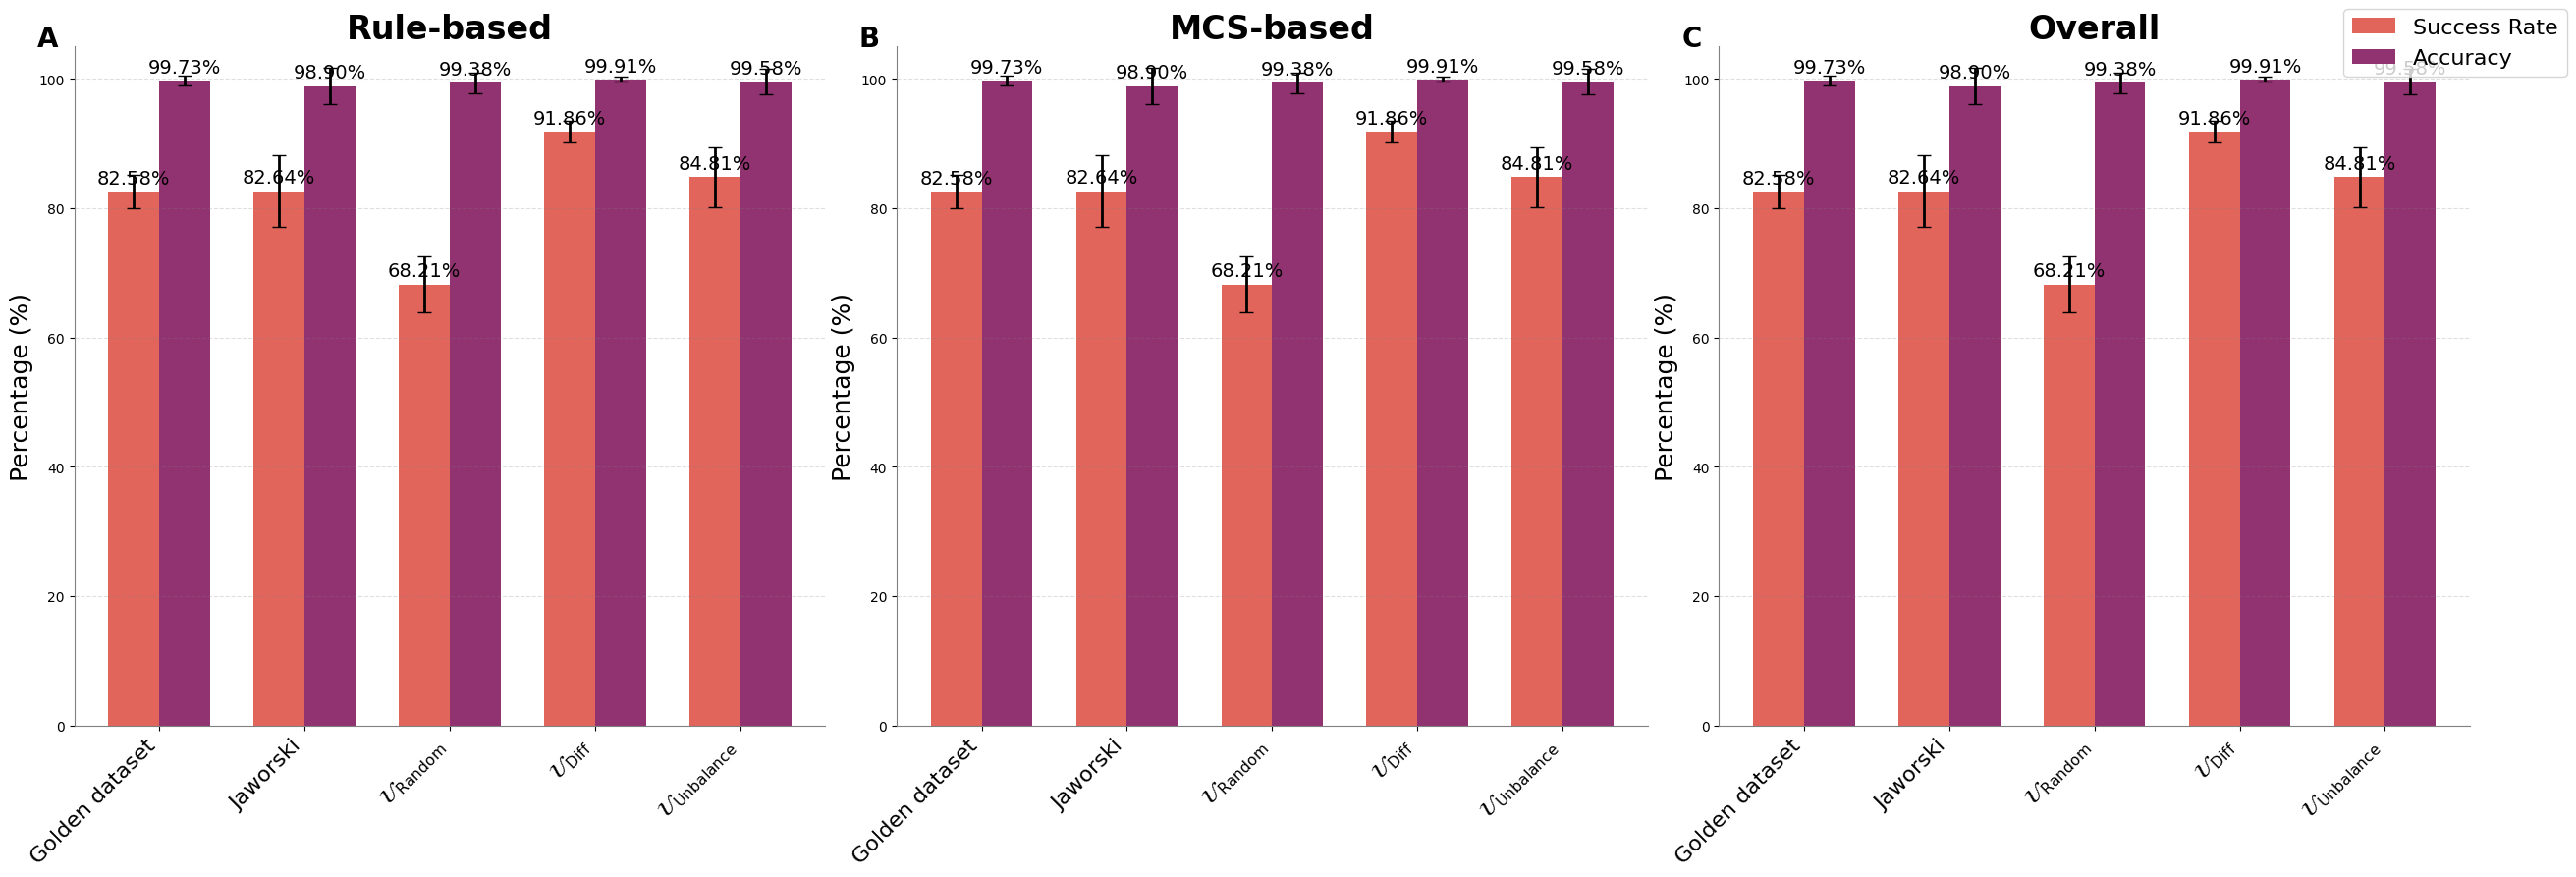

In [3]:
import pandas as pd
import numpy as np
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])
data = pd.DataFrame({'Dataset': datasets, 'Success Rate': success_rate, 'Accuracy': accuracy, 'Unbalance': unbalance})
from SynAnalysis.visualizer import barplot_accuracy_comparison
barplot_accuracy_comparison([data,data,data], layout='horizontal', show_values=True, save_path='accuracy_bar_plot.pdf')


In [4]:
from SynRBL.SynMCSImputer.SubStructure.mcs_process import ensemble_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import find_graph_dict
from SynRBL.SynMCSImputer.MissingGraph.refinement_uncertainty import RefinementUncertainty

mcs1 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_1.json.gz')
mcs2 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_2.json.gz')
mcs3 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_3.json.gz')
mcs4 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_4.json.gz')
mcs5 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_5.json.gz')
datasets = ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble']
golden = [256, 279, 211, 269, 398, 195]
jaworski = [26, 30, 22, 33, 46, 21]
random = [66, 80, 60, 75, 203, 60]
diff = [44, 50, 42, 45, 128, 40]
unbalance = [37, 37, 33, 35, 130, 33]

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)


In [5]:
from SynAnalysis.visualizer import mcs_comparsion
mcs_comparsion([mcs1, mcs1, mcs2, mcs3, mcs4, mcs5], df, 67)

NameError: name 'mcs1' is not defined

In [6]:

list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)

data_check = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions','Index', 'mcs_carbon_balanced'], axis =1)



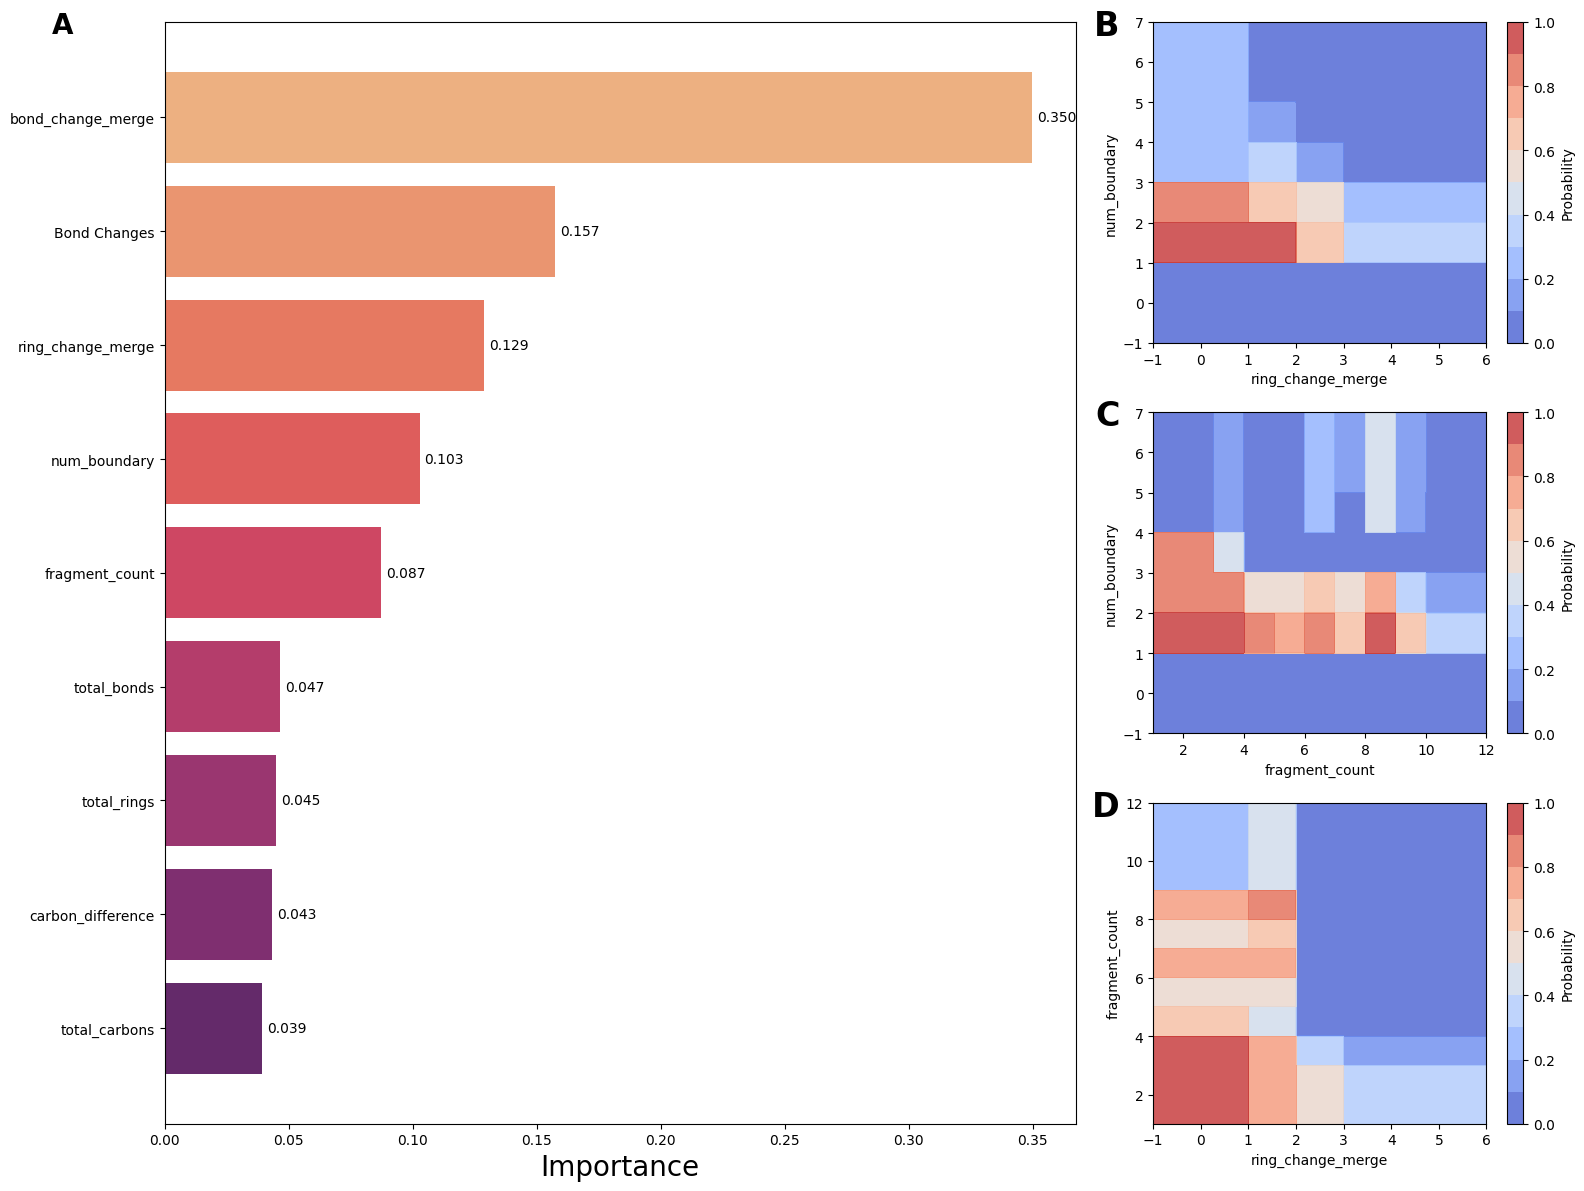

In [7]:
from SynAnalysis.feature_analysis import FeatureAnalysis
vis = FeatureAnalysis(data_check, 'Result', [('ring_change_merge','num_boundary'),
                                           ('fragment_count','num_boundary'), 
                                           ('ring_change_merge','fragment_count')])
vis.visualize(save_path=None)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipeline
from SynAnalysis.analysis_process import AnalysisProcess
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path, data_path)
data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)

data_raw = data_raw.drop_duplicates()
X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.79      0.65        52
           1       0.95      0.87      0.91       255

    accuracy                           0.85       307
   macro avg       0.75      0.83      0.78       307
weighted avg       0.88      0.85      0.86       307



In [34]:
data_raw.drop_duplicates().shape

(1531, 9)

In [28]:
data_raw.shape

(2255, 9)

In [27]:
X

,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,num_boundary,ring_change_merge,bond_change_merge
0,2,3,20,1,0,1,0,1
1,7,2,37,11,1,2,1,0
2,2,2,54,2,0,1,0,0
3,2,3,60,2,0,1,0,0
4,2,3,18,1,0,1,0,1
...,...,...,...,...,...,...,...,...
2250,2,3,32,1,1,1,1,1
2251,2,3,30,1,1,1,1,1
2252,3,3,19,2,1,1,1,2
2253,3,3,49,2,1,1,1,2


In [7]:
y_proba = pipeline.predict_proba(X_test)

In [9]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_proba[:,0], pos_label=0)

0.8249088599160175

In [10]:
y_proba[0]

array([2.4873018e-04, 9.9975127e-01], dtype=float32)

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors
from typing import List, Optional
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.gridspec import GridSpec
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

def classification_visualization(y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray, save_path: str = None, figsize: tuple = (14, 14)):
    """
    Visualize classification metrics including Confusion Matrix, Classification Report, ROC Curve, and Precision-Recall Curve.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred (np.ndarray): Predicted labels.
    y_proba (np.ndarray): Predicted probabilities.
    save_path (str, optional): Path to save the figure. If None, the figure is not saved. Default is None.
    figsize (tuple, optional): Figure size (width, height). Default is (14, 14).

    Returns:
    None
    """
    # Setup the matplotlib figure and axes, 2x2 layout
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    #fig.suptitle('Advanced Classification Metrics Visualization', fontsize=16)

    labels = ['A', 'B', 'C', 'D']  # Labels for each subplot
    for ax, label in zip(axes.flat, labels):
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, size=20, weight='bold', va='top', ha='right')

    # Subfig 1: Confusion Matrix
    ax = axes[0, 0]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 14})
    ax.set(xlabel='Predicted labels', ylabel='True labels')
    ax.set_title('Confusion Matrix', fontsize=18, weight='bold', pad=20)

    # Subfig 2: Classification Report
    ax = axes[0, 1]
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='Spectral', cbar=True, fmt=".2f", ax=ax, annot_kws={"size": 14})
    ax.set_title('Classification Report', fontsize=18, weight='bold', pad=20)

    # Enhance ROC Curve visual
    ax = axes[1, 0]
    fpr, tpr, thresholds = roc_curve(y_true, y_proba[:, 0], pos_label=0)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc, color='darkorange', lw=2)
    ax.fill_between(fpr, tpr, color='darkorange', alpha=0.3)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy')
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax.set_title('ROC Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower right")

    # Enhance Precision-Recall Curve visual
    ax = axes[1, 1]
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:,0], pos_label=0)
    average_precision = average_precision_score(y_true, y_proba[:,0], pos_label=0)
    ax.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision, color='blue', lw=2)
    ax.fill_between(recall, precision, color='blue', alpha=0.3)
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel='Recall', ylabel='Precision')
    ax.set_title('Precision-Recall Curve', fontsize=18, weight='bold', pad=20)

    ax.legend(loc="lower left")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        plt.savefig(save_path, dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

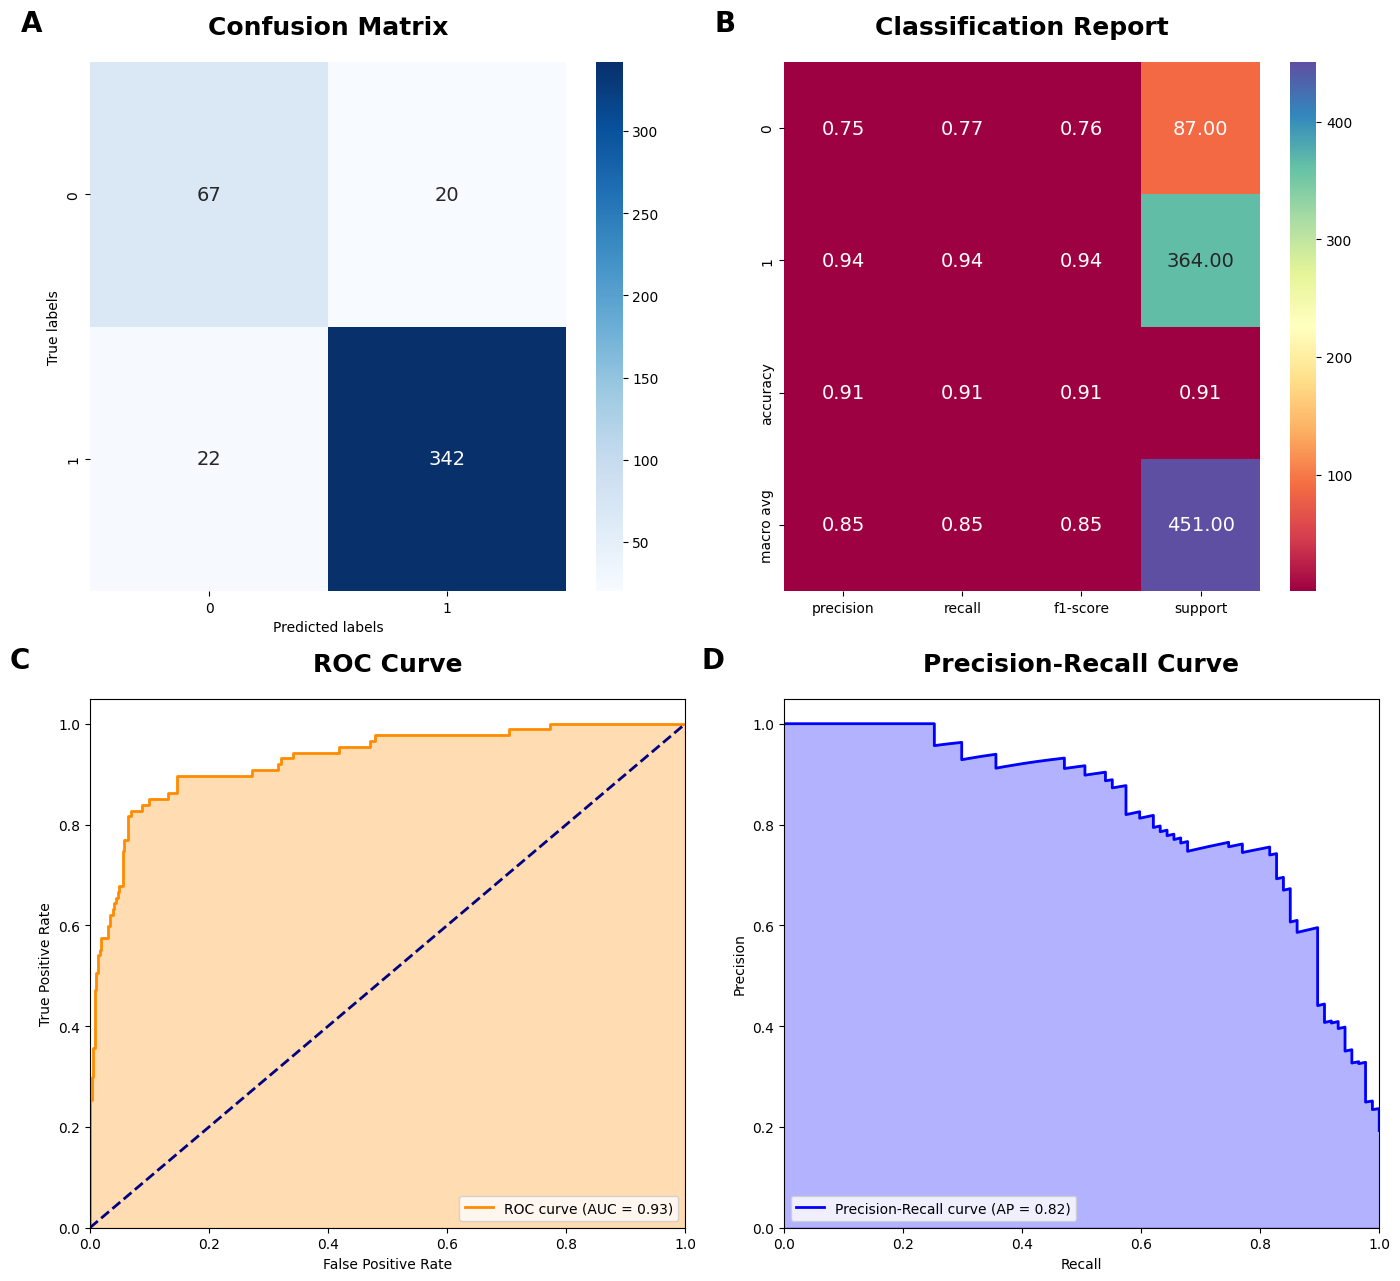

In [21]:
#from SynAnalysis.visualizer import classification_visualization

classification_visualization(y_test, y_pred, pipeline.predict_proba(X_test),
                             save_path = 'model_performance.pdf', figsize = (14, 14))

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipeline
from SynAnalysis.analysis_process import AnalysisProcess
list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_diff', 'USPTO_unbalance_class']
input_path = '../../../Pipeline'
source_path = '../../../Data'
process = AnalysisProcess(list_data, pipeline_path=input_path, data_path=source_path)

data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)



X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)



Pipeline(steps=[('scaler', MinMaxScaler()),
                ('over',
                 SMOTEENN(random_state=42, sampling_strategy='minority')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None...ow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [21]:
data_raw.columns

Index(['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'Result', 'num_boundary', 'ring_change_merge',
       'bond_change_merge'],
      dtype='object')

In [ ]:
def pr

In [54]:
from typing import List, Union
from pandas import DataFrame
from SynRBL.rsmi_utils import load_database
import pickle
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles, calculate_chemical_properties, count_boundary_atoms_products_and_calculate_changes
from IPython.display import clear_output
import pandas as pd
import numpy as np

def confidence_level(merge_data_path: str, mcs_data_path: str, scoring_function_path: str, remove_undetected: bool = True) -> List[float]:
    """
    Calculates the confidence level for chemical reactions based on their properties and a pre-trained model.
    
    This function loads merged and MCS (Maximum Common Substructure) reaction data, calculates various chemical
    properties, and uses a pre-trained model to predict a confidence level for each reaction.
    
    Parameters:
    - merge_data_path (str): Path to the file containing merged reaction data.
    - mcs_data_path (str): Path to the file containing MCS reaction data.
    - scoring_function_path (str): Path to the pre-trained model file (pickle format).
    - remove_undetected (bool, optional): If True, removes reactions where the MCS carbon balance is not detected. Defaults to True.
    
    Returns:
    - List[float]: A list of confidence scores for each reaction, based on the predictions from the pre-trained model.
    
    Note:
    - The function assumes that the reaction data includes specific fields such as 'R-id' for reaction ID and chemical property columns.
    - The pre-trained model should be capable of providing probability estimates through a `predict_proba` method.
    """
    
    # Load and process merge data
    merge_data = load_database(merge_data_path)
    merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
    
    # Load and process MCS data
    mcs_data = load_database(mcs_data_path)
    id = [value['R-id'] for value in merge_data]
    mcs_data = [value for value in mcs_data if value['R-id'] in id]
    mcs_data = calculate_chemical_properties(mcs_data)
    
    # Clear output
    clear_output(wait=False)
    
    # Combine data and filter if necessary
    combined_data = pd.concat([
        pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
        pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge', 'new_reaction']],
    ], axis=1)
    
    # if remove_undetected:
    #     combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
    
    combined_data = combined_data.reset_index(drop=True)
    unnamed_columns = [col for col in combined_data.columns if 'Unnamed' in col]
    combined_data = combined_data.drop(unnamed_columns, axis=1)
    
    # Prepare data for prediction
    X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings', 'num_boundary', 'ring_change_merge', 'bond_change_merge']]
    
    # Load model and predict confidence
    with open(scoring_function_path, 'rb') as file:
        loaded_model = pickle.load(file)
    
    confidence = np.round(loaded_model.predict_proba(X_pred)[:, 1],3)
    combined_data['confidence'] = confidence
    
    return combined_data[['R-id', 'reactions', 'new_reaction', 'confidence', 'mcs_carbon_balanced']]


In [55]:
data_pred = confidence_level(merge_data_path= '../../../Data/Validation_set/USPTO_diff/MCS/MCS_Impute.json.gz', 
                              mcs_data_path = '../../../Data/Validation_set/USPTO_diff/mcs_based_reactions.json.gz', 
                              scoring_function_path='./scoring_function.pkl', remove_undetected=True)

In [56]:
data_pred

,R-id,reactions,new_reaction,confidence,mcs_carbon_balanced
0,USPTO_diff_1151,Cc1nc(C(=O)N2CCC[C@@H](C)[C@H]2CNC(=O)OC(C)(C)...,Cc1nc(C(=O)N2CCC[C@@H](C)[C@H]2CNC(=O)OC(C)(C)...,0.999,True
1,USPTO_diff_1152,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1c([C@@H]2CN3C...,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1c([C@@H]2CN3C...,0.999,True
2,USPTO_diff_1153,O=C(OCc1ccccc1)c1cc(C(F)(F)F)cc(S(=O)(=O)Cc2cc...,O=C(OCc1ccccc1)c1cc(C(F)(F)F)cc(S(=O)(=O)Cc2cc...,0.999,True
3,USPTO_diff_1212,O=C(NC(Cc1ccc2[nH]ncc2c1)C(=O)N1CCN(C(=O)OCc2c...,O=C(NC(Cc1ccc2[nH]ncc2c1)C(=O)N1CCN(C(=O)OCc2c...,1.000,True
4,USPTO_diff_1213,O=CN(O)[C@H](CS(=O)(=O)CC1Cc2ccccc2C1)c1cccc(N...,O=CN(O)[C@H](CS(=O)(=O)CC1Cc2ccccc2C1)c1cccc(N...,1.000,True
...,...,...,...,...,...
473,USPTO_diff_1624,CCC(=O)c1ccc2c(c1)ncn2C.O=C(c1ccc(O)cc1)c1ccc(...,CCC(=O)c1ccc2c(c1)ncn2C.O=C(c1ccc(O)cc1)c1ccc(...,0.999,True
474,USPTO_diff_1625,Clc1ccc(C=C(Br)Br)c(Cl)c1>>C#Cc1ccc(Cl)cc1Cl,Clc1ccc(C=C(Br)Br)c(Cl)c1>>C#Cc1ccc(Cl)cc1Cl.B...,0.989,True
475,USPTO_diff_1626,COC(=O)c1ccc(F)cc1Br.O=[N+]([O-])c1ccc(F)cc1Br...,COC(=O)c1ccc(F)cc1Br.O=[N+]([O-])c1ccc(F)cc1Br...,0.998,True
476,USPTO_diff_1627,CCC(C(N)=O)N1CC(C=C(Br)Br)CC1=O>>C#CC1CC(=O)N(...,CCC(C(N)=O)N1CC(C=C(Br)Br)CC1=O>>C#CC1CC(=O)N(...,0.996,True


In [ ]:
from SynRBL.rsmi_utils import load_database
import pickle
from SynAnalysis.analysis_utils import remove_atom_mapping_from_reaction_smiles,calculate_chemical_properties, count_boundary_atoms_products_and_calculate_changes
from IPython.display import clear_output
def confidence_level(merge_data_path, mcs_data_path, scoring_function_path, remove_undetected=True):        
    merge_data = load_database(merge_data_path)
    merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
    mcs_data = load_database(mcs_data_path)
    id = [value['R-id'] for value in merge_data]
    mcs_data = [value for value in mcs_data if value['R-id'] in id]
    mcs_data = calculate_chemical_properties(mcs_data)
    clear_output(wait=False)
    
    combined_data = pd.concat([
        pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
        pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge']],
    ], axis=1)
    if remove_undetected:
        combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
    
    combined_data = combined_data.reset_index(drop=True)
    unnamed_columns = [col for col in combined_data.columns if 'Unnamed' in col]
    combined_data = combined_data.drop(unnamed_columns, axis=1)

    X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'num_boundary', 'ring_change_merge',
       'bond_change_merge']]
    
    with open(scoring_function_path, 'rb') as file:
        loaded_model = pickle.load(file)

    confidence = loaded_model.predict_proba(X_pred)[:,1]
    return confidence

In [25]:
from SynRBL
import pickle
data_predict_name = 'USPTO_unbalance_class'
input_path = '../../../Pipeline'
source_path = '../../../Data'
process = AnalysisProcess(pipeline_path=input_path, data_path=source_path, data_predict_name=data_predict_name)
combined_data=process.process_predict_datasets()

X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'num_boundary', 'ring_change_merge',
       'bond_change_merge']]


with open('scoring_function.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

confidence = loaded_model.predict_proba(X_pred)[:,1]
confidence

array([0.9732179 , 0.9999201 , 0.9985556 , 0.980602  , 0.9994814 ,
       0.99960846, 0.996942  , 0.9997547 , 0.9991072 , 0.996942  ,
       0.81488943, 0.9979438 , 0.9999739 , 0.99693775, 0.99997175,
       0.9999796 , 0.9997789 , 0.9983606 , 0.99569464, 0.9732179 ,
       0.9966897 , 0.99997175, 0.9997547 , 0.9994814 , 0.999524  ,
       0.9999201 , 0.99991834, 0.9972173 , 0.9998772 , 0.9998305 ,
       0.99995875, 0.99995875, 0.999982  , 0.99998736, 0.99918705,
       0.99995875, 0.999982  , 0.99932504, 0.99966395, 0.9998124 ,
       0.9996126 , 0.99996805, 0.37905622, 0.99995875, 0.99564797,
       0.9999026 , 0.96296096, 0.99918467, 0.99918467, 0.73850137,
       0.9989262 , 0.999982  , 0.9997749 , 0.99979204, 0.9997925 ,
       0.9976883 , 0.99984026, 0.999213  , 0.99833053, 0.9997882 ,
       0.99975127, 0.99975127, 0.9997447 , 0.99971336, 0.9997882 ,
       0.9806889 , 0.99975127, 0.9999243 , 0.9994773 , 0.9994773 ,
       0.99960405, 0.9990814 , 0.9998111 , 0.999571  , 0.99997

In [ ]:
data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)



X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)

In [ ]:
X_pred = combined_data[['carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds',
       'total_rings', 'num_boundary', 'ring_change_merge',
       'bond_change_merge']]

In [19]:
combined_data.columns

Index(['R-id', 'reactions', 'carbon_difference', 'fragment_count',
       'total_carbons', 'total_bonds', 'total_rings', 'mcs_carbon_balanced',
       'num_boundary', 'ring_change_merge', 'bond_change_merge'],
      dtype='object')

In [6]:
import pickle
with open('scoring_function.pkl', 'wb') as file:
    pickle.dump(pipeline, file)


In [8]:

with open('scoring_function.pkl', 'rb') as file:
    loaded_model = pickle.load(file)



In [10]:
X_test

,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,num_boundary,ring_change_merge,bond_change_merge
2064,5,3,27,7,0,1,0,0
1263,5,3,33,7,0,1,0,0
2128,4,3,24,7,1,1,0,0
599,18,6,66,32,2,2,0,0
464,1,8,37,3,0,1,0,0
...,...,...,...,...,...,...,...,...
1880,7,2,33,10,1,1,0,0
427,8,5,66,8,0,2,0,1
374,1,2,41,1,2,1,2,2
105,6,4,18,10,0,2,0,0


In [9]:
loaded_model.predict_proba(X_test)

array([[2.48730183e-04, 9.99751270e-01],
       [3.06487083e-04, 9.99693513e-01],
       [6.47306442e-05, 9.99935269e-01],
       [4.03838813e-01, 5.96161187e-01],
       [6.77817464e-02, 9.32218254e-01],
       [3.95953655e-04, 9.99604046e-01],
       [4.53586578e-02, 9.54641342e-01],
       [1.16554499e-02, 9.88344550e-01],
       [7.65562057e-04, 9.99234438e-01],
       [4.88758087e-05, 9.99951124e-01],
       [1.48475945e-01, 8.51524055e-01],
       [9.99754846e-01, 2.45162752e-04],
       [8.79271328e-01, 1.20728694e-01],
       [6.47306442e-05, 9.99935269e-01],
       [4.23701048e-01, 5.76298952e-01],
       [9.92853820e-01, 7.14617502e-03],
       [1.79111958e-04, 9.99820888e-01],
       [6.76167011e-03, 9.93238330e-01],
       [5.46404719e-02, 9.45359528e-01],
       [1.69992447e-04, 9.99830008e-01],
       [9.58025455e-04, 9.99041975e-01],
       [3.79323959e-04, 9.99620676e-01],
       [8.27478051e-01, 1.72521964e-01],
       [2.15003490e-02, 9.78499651e-01],
       [2.193987

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as Pipeline

data_raw = process.process_and_combine_datasets(remove_undetected=False).drop(['R-id', 'reactions', 'Bond Changes',
                                                                                'Index', 'mcs_carbon_balanced'], axis =1)


X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

steps = [('scaler', MinMaxScaler()), ('over', SMOTEENN(sampling_strategy='minority', random_state=42)), ('model', XGBClassifier(random_state=42))]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))